In [9]:
import re
import warnings
warnings.filterwarnings('ignore')

from ulteis import preprocess, vectorize

import gensim
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel, LsiModel, Nmf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [24]:
# Lendo o dataset e separando os dados e as classes

bbc_df = pd.read_csv("../data/bbc_data.csv")

#bbc_df["labels"] = bbc_df["labels"].map({"entertainment": 0, "tech": 1, "business": 2, "politics": 3, "sport": 4})

X_train, X_test, y_train, y_test = train_test_split(bbc_df["data"], bbc_df["labels"], test_size=0.30, random_state=42)

# Preprocessamento
X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)


bbc_df.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


## Para essa etapa fica a escolha a opção de lematizar ou stimizar, em parcular como iremos trabalhar com modelagem de topico mais a fente é mais adaquado para faciliatar a analize lematizar

In [11]:
# Preprocessamento

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)


print(X_train[22], '\n')
print(X_test[29], '\n')

producer scoop stage award producer beaten mary poppins battle blockbuster west end musical olivier award producer three prize uk prestigious annual theatre award mary poppins two mel brook hit show triumphed battle best new musical mary poppins andrew lloyd webbers woman white alan bennett history boy big winner straight theatre category picking three trophy eye musical prize producer mary poppins woman white high profile opening last six month producer nathan lane last minute replacement richard dreyfus beat former co star lee evans win best musical actor lane already left production smash hit broadway moving london show also best musical performance supporting role conleth hill play director roger debris mary poppins award came best choreography best musical actress star laura michelle kelly led nomination going sunday ceremony london hilton hotel nine award show stage adaptation film history boy set grammar school early partly based bennett experience teacher named best new play al

In [17]:
# Vectors Bag of words
cv = CountVectorizer()
cv_df, cv_df_test = vectorize(cv,X_train, X_test)

# Vectors TF-IDF
tfidf = TfidfVectorizer()
tfidf_df, tfidf_df_test = vectorize(tfidf,X_train, X_test)



In [18]:
# Metrics analysis

def metrics_describe(model, df_test_cv, df_test_tfidf):
    y_pred = model.predict(df_test)
    
    #metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    #plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    classes = model.classes_
    
    # Plotar a matriz de confusão no primeiro subplot
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=ax1,xticklabels=classes, yticklabels=classes)
    ax1.set_title('Matriz de Confusão')
    ax1.set_xlabel('Classe Prevista')
    ax1.set_ylabel('Classe Verdadeira')

    # Escrever as métricas no segundo subplot
    ax2.axis('off')  # Esconde os eixos
    metrics_text = f"""Métricas:
    Accuracy:  {accuracy:.2f}
    Precision: {precision:.2f}
    Recall:    {recall:.2f}
    F1 Score:  {f1:.2f}"""

    ax2.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    plt.show()

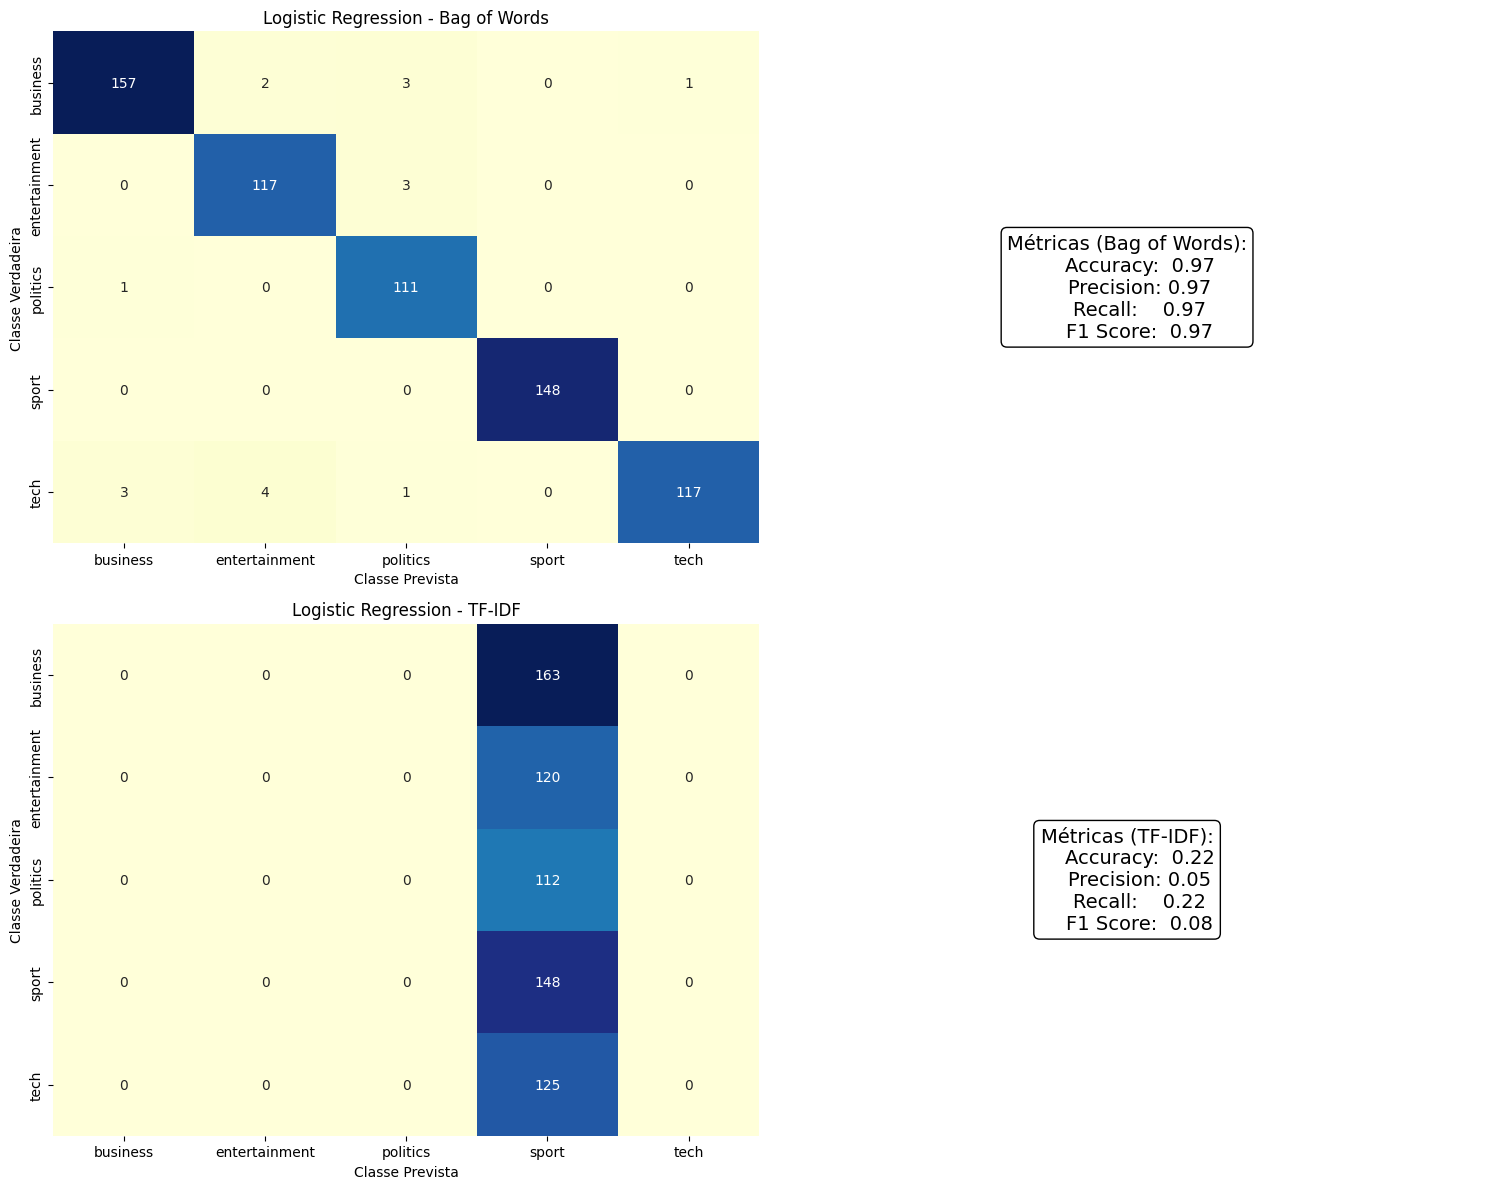

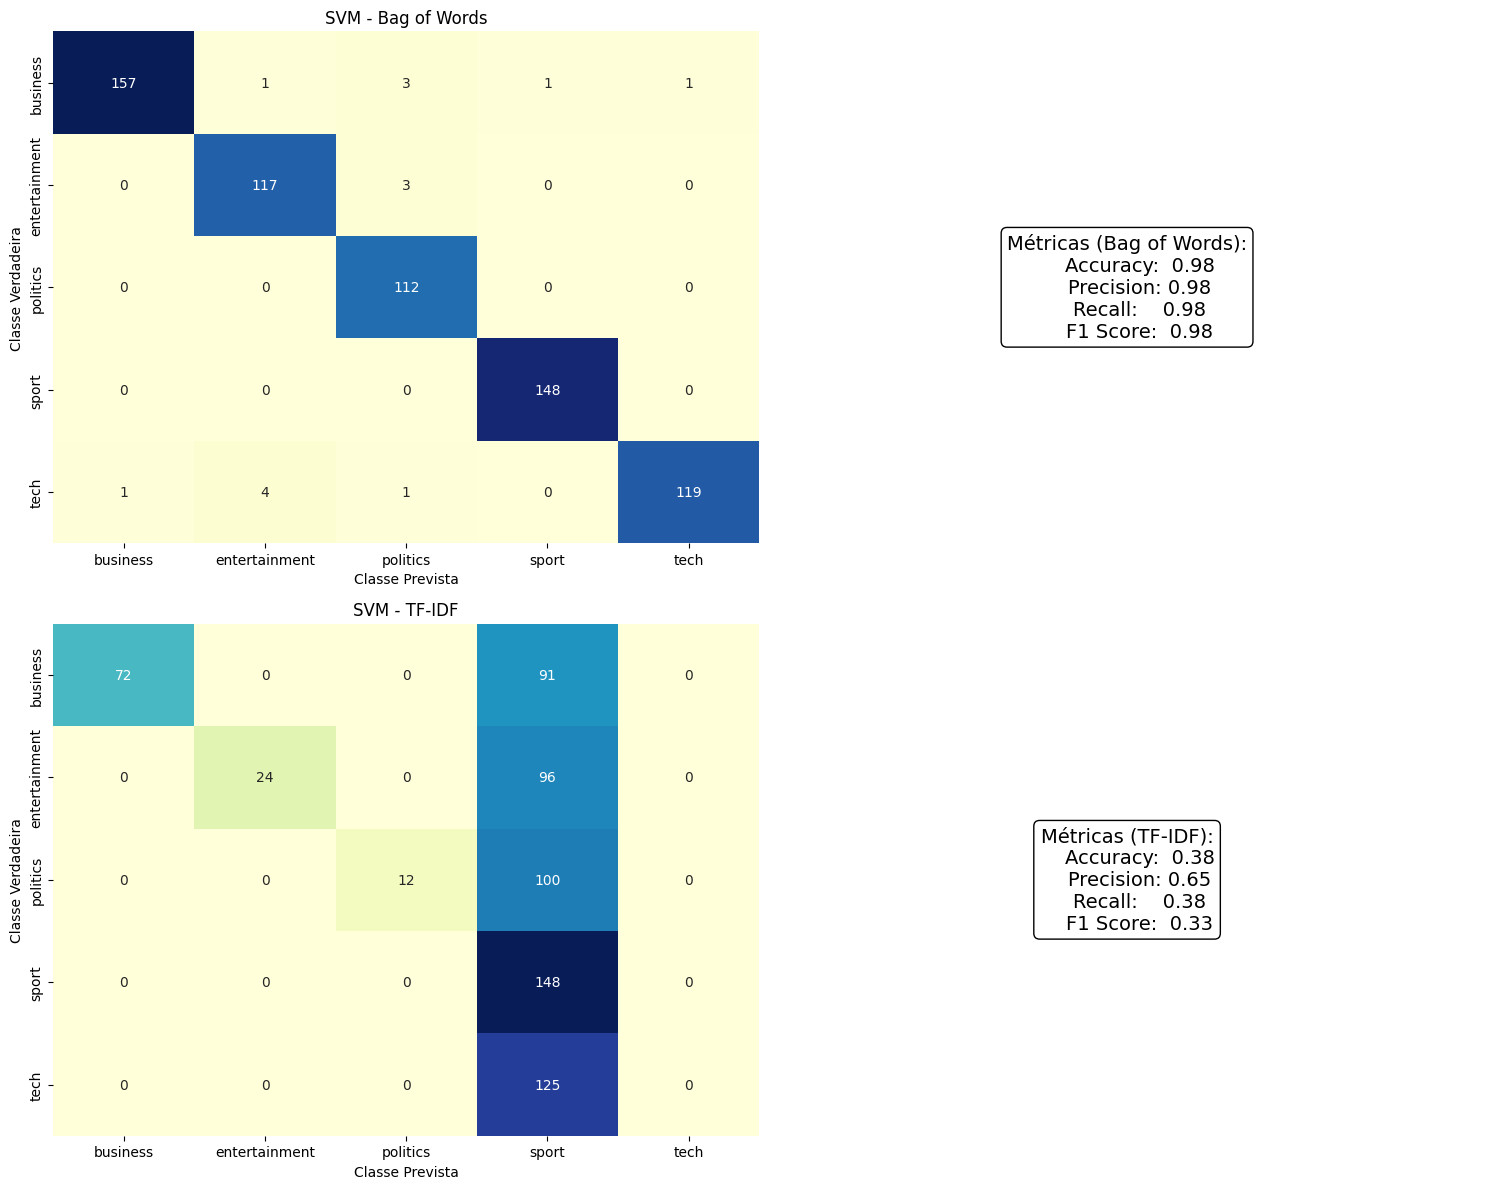

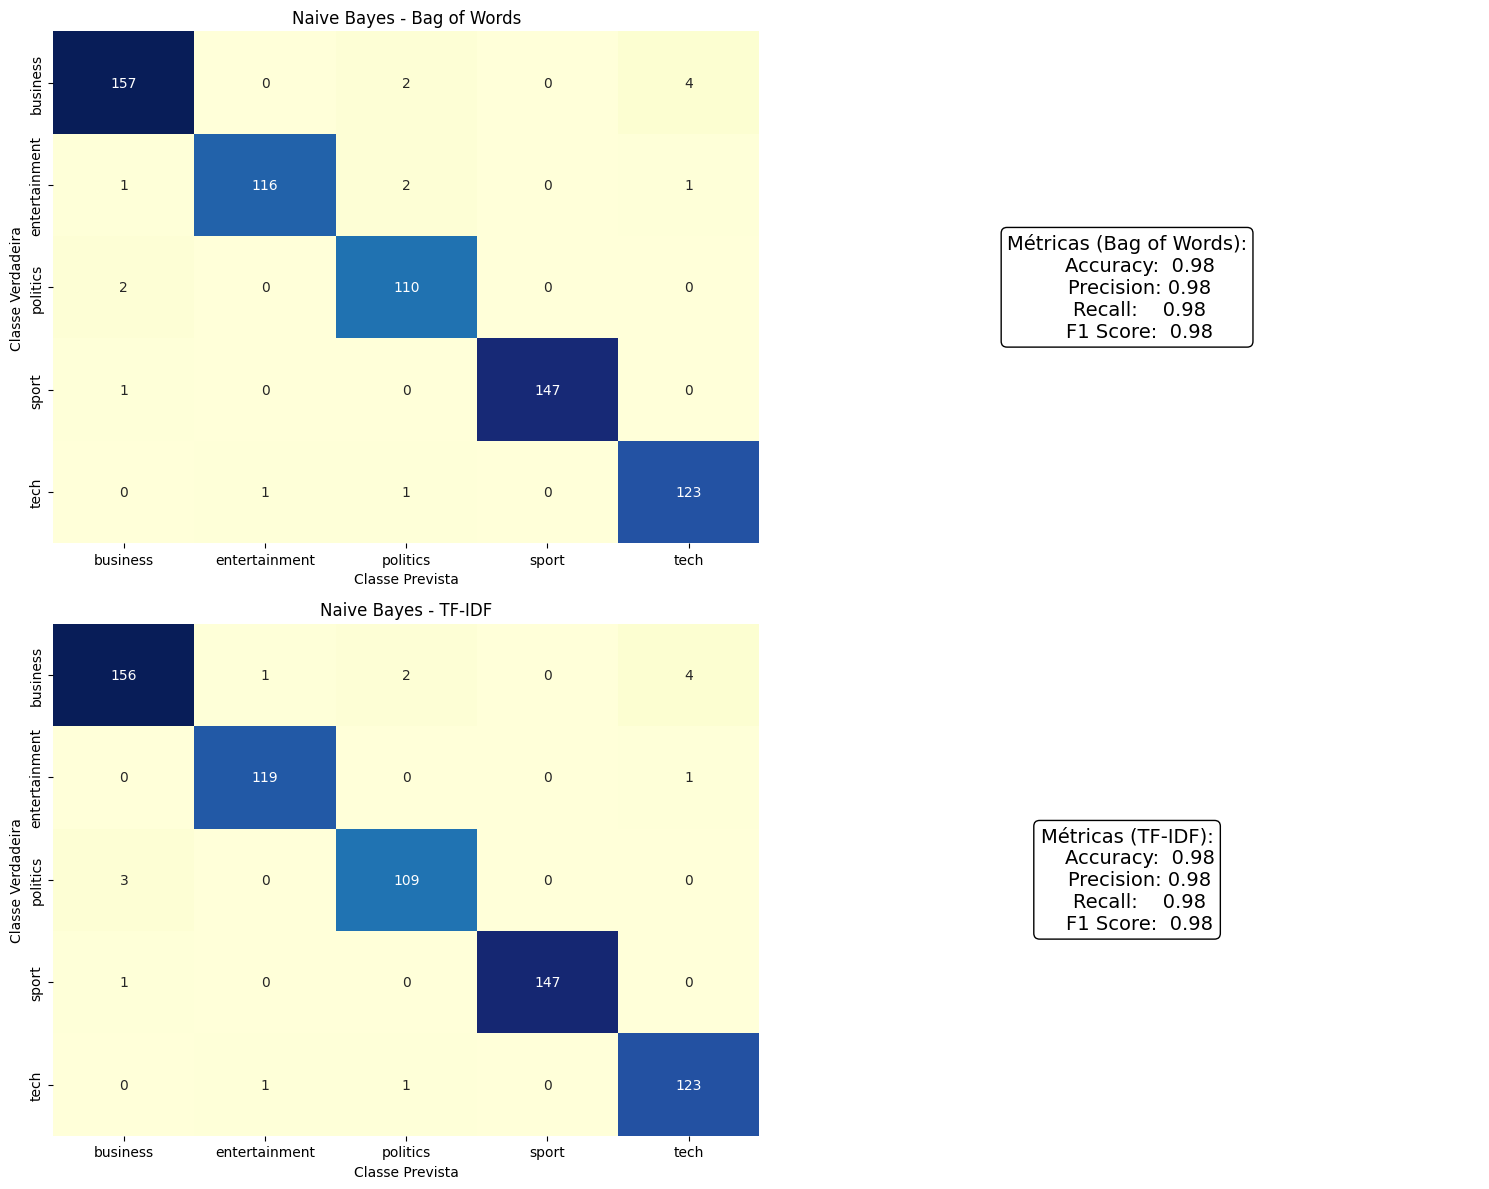

In [25]:
def metrics_describe(model, df_test_cv, df_test_tfidf, model_name):
    y_pred_cv = model.predict(df_test_cv)
    y_pred_tfidf = model.predict(df_test_tfidf)
    
    # Metrics para Bag of Words
    accuracy_cv = accuracy_score(y_test, y_pred_cv)
    precision_cv = precision_score(y_test, y_pred_cv, average="weighted")
    recall_cv = recall_score(y_test, y_pred_cv, average="weighted")
    f1_cv = f1_score(y_test, y_pred_cv, average="weighted")
    conf_matrix_cv = confusion_matrix(y_test, y_pred_cv)

    # Metrics para TF-IDF
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    precision_tfidf = precision_score(y_test, y_pred_tfidf, average="weighted")
    recall_tfidf = recall_score(y_test, y_pred_tfidf, average="weighted")
    f1_tfidf = f1_score(y_test, y_pred_tfidf, average="weighted")
    conf_matrix_tfidf = confusion_matrix(y_test, y_pred_tfidf)
    
    # Plot com gráficos 3x2 (3 modelos e 2 vetorizadores)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 3x2 grid
    
    # Classes
    classes = model.classes_
    
    # Bag of Words - Matriz de Confusão
    sns.heatmap(conf_matrix_cv, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=axes[0, 0], 
                xticklabels=classes, yticklabels=classes)
    axes[0, 0].set_title(f'{model_name} - Bag of Words')
    axes[0, 0].set_xlabel('Classe Prevista')
    axes[0, 0].set_ylabel('Classe Verdadeira')
    
    # TF-IDF - Matriz de Confusão
    sns.heatmap(conf_matrix_tfidf, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=axes[1,0 ], 
                xticklabels=classes, yticklabels=classes)
    axes[1, 0].set_title(f'{model_name} - TF-IDF')
    axes[1, 0].set_xlabel('Classe Prevista')
    axes[1, 0].set_ylabel('Classe Verdadeira')
    
    # Métricas para Bag of Words
    metrics_text_cv = f"""Métricas (Bag of Words):
    Accuracy:  {accuracy_cv:.2f}
    Precision: {precision_cv:.2f}
    Recall:    {recall_cv:.2f}
    F1 Score:  {f1_cv:.2f}"""
    axes[0, 1].text(0.5, 0.5, metrics_text_cv, fontsize=14, ha='center', va='center', 
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    axes[0, 1].axis('off')
    
    # Métricas para TF-IDF
    metrics_text_tfidf = f"""Métricas (TF-IDF):
    Accuracy:  {accuracy_tfidf:.2f}
    Precision: {precision_tfidf:.2f}
    Recall:    {recall_tfidf:.2f}
    F1 Score:  {f1_tfidf:.2f}"""
    axes[1, 1].text(0.5, 0.5, metrics_text_tfidf, fontsize=14, ha='center', va='center', 
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    axes[1, 1].axis('off')

    # Ajuste de layout
    plt.tight_layout()
    plt.show()

# Função para treinar os modelos e gerar os gráficos
def run_models():
    # Vectors Bag of words
    cv = CountVectorizer()
    cv_df = cv.fit_transform(X_train)
    cv_df_test = cv.transform(X_test)

    # Vectors TF-IDF
    tfidf = TfidfVectorizer()
    tfidf_df = tfidf.fit_transform(X_train)
    tfidf_df_test = tfidf.transform(X_test)

    # Modelos utilizados
    classifiers = {
        "Logistic Regression": LogisticRegression(),
        "SVM": LinearSVC(),
        "Naive Bayes": MultinomialNB()
    }

    for model_name, model in classifiers.items():
        # Treinando o modelo com Bag of Words
        model.fit(cv_df, y_train)
        
        # Gerar gráficos para Bag of Words e TF-IDF
        metrics_describe(model, cv_df_test, tfidf_df_test, model_name)
# Chamando a função para rodar os modelos
run_models()


## O seguintes resultados são referentes a vetorização com Bang of Words

In [15]:
# modelos utilizados
clf = LogisticRegression()
svm = LinearSVC()
nb = MultinomialNB()

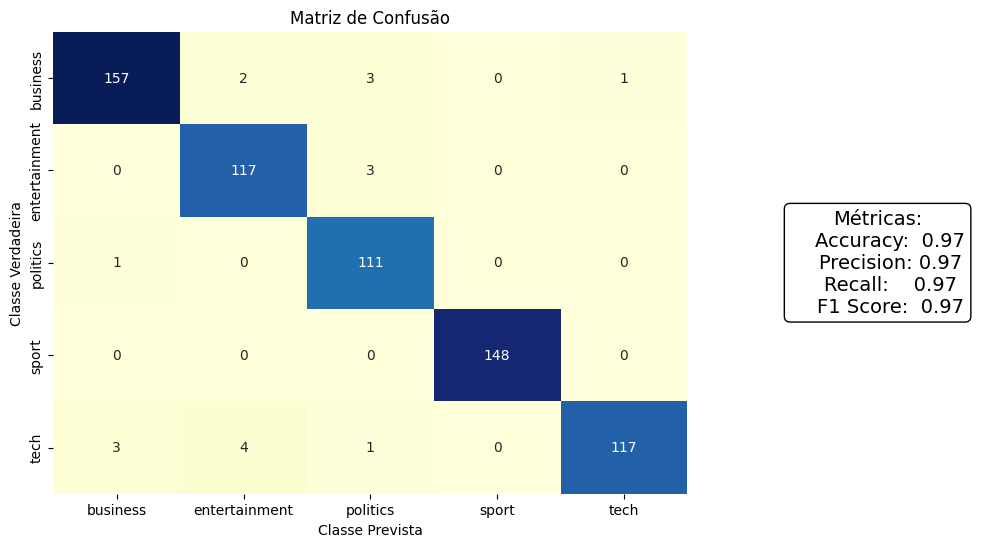

In [11]:
# Logistic Regression

clf.fit(cv_df, y_train)
metrics_describe(clf, cv_df_test)

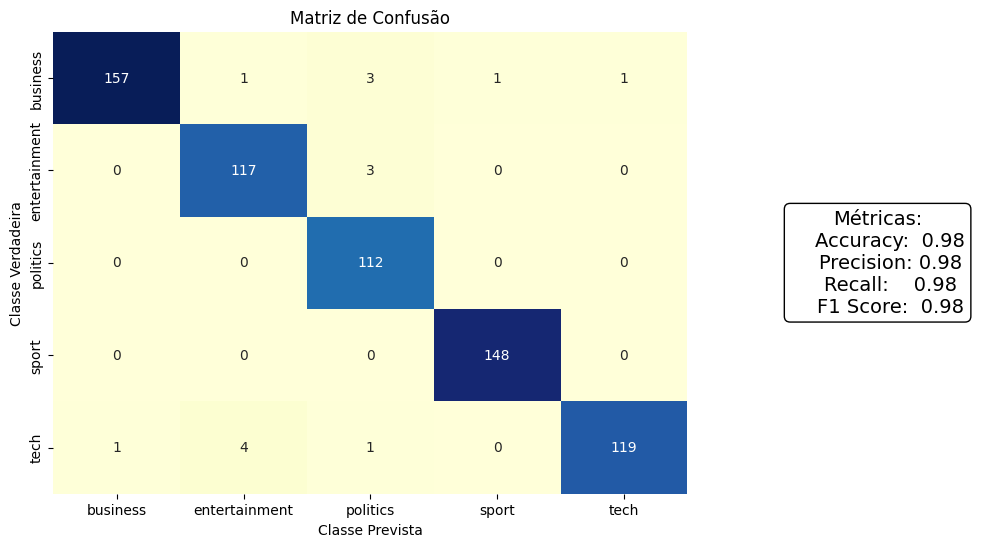

In [12]:
svm.fit(cv_df, y_train)
metrics_describe(svm, cv_df_test)

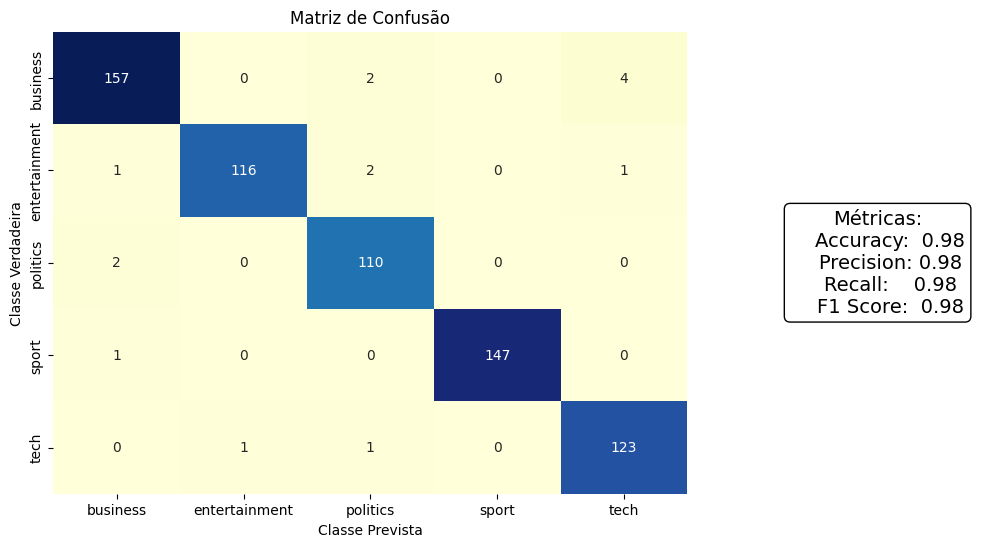

In [13]:
nb.fit(cv_df, y_train)
metrics_describe(nb, cv_df_test)

## O seguintes resultados são referentes a vetorização com TF-IDF

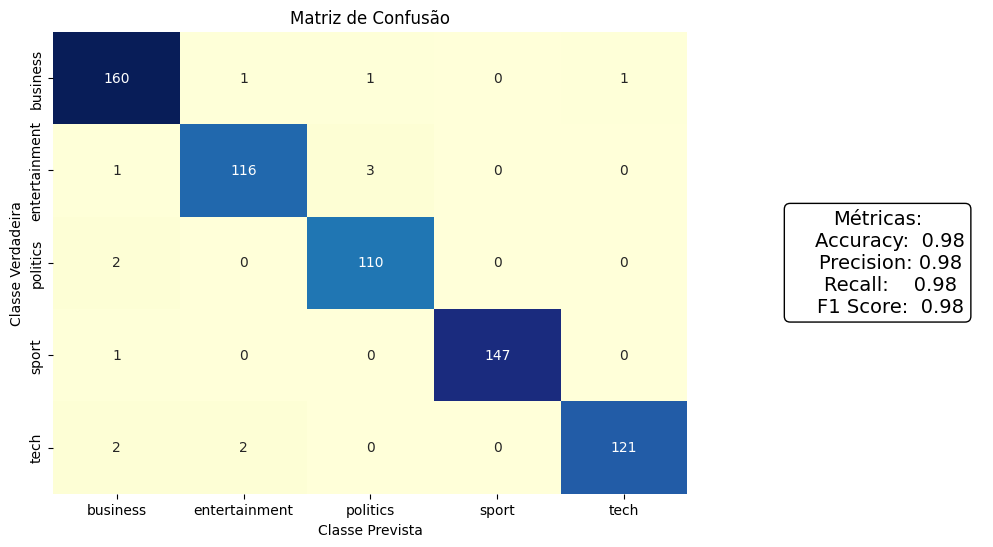

In [21]:
clf.fit(tfidf_df, y_train)
metrics_describe(clf, tfidf_df_test)

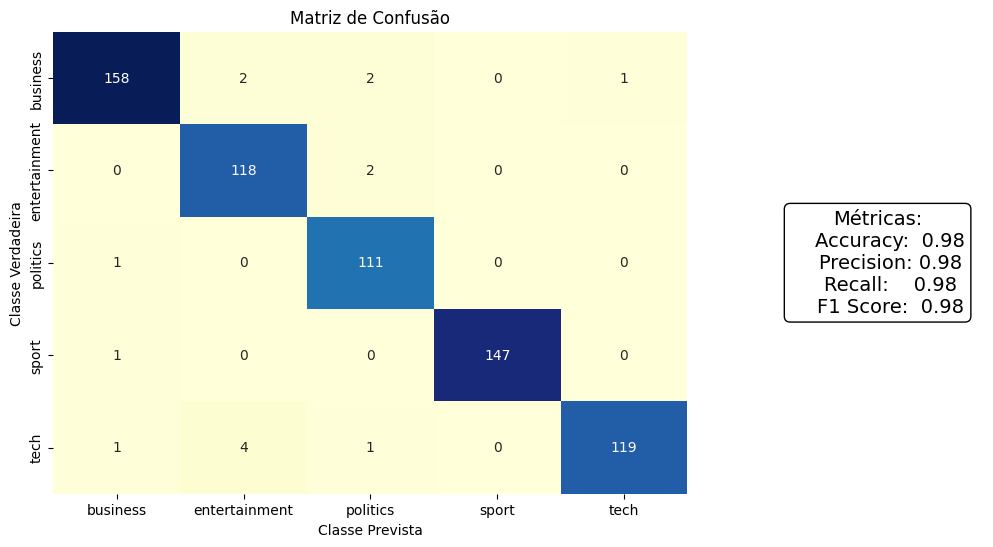

In [20]:
svm.fit(tfidf_df, y_train)
metrics_describe(svm, tfidf_df_test)

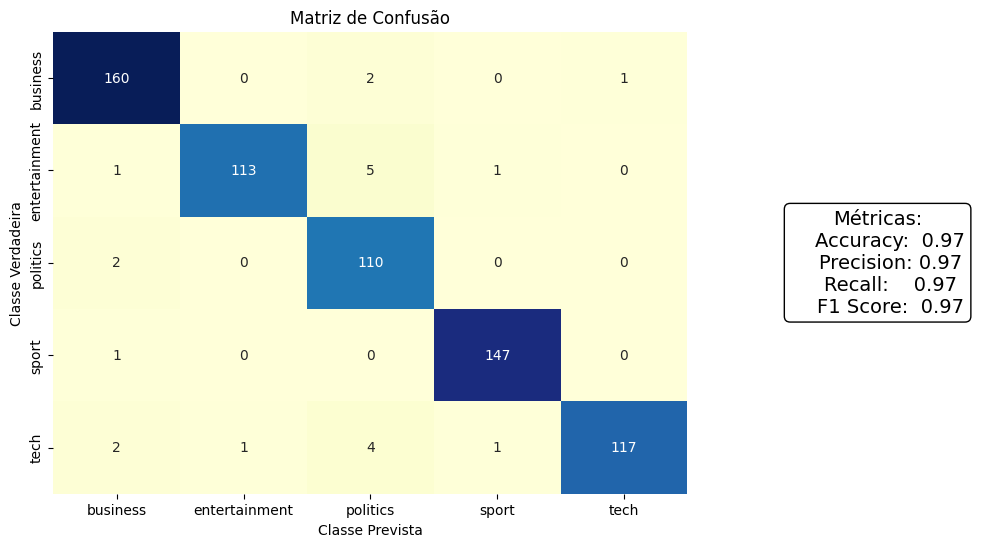

In [19]:
nb.fit(tfidf_df, y_train)
metrics_describe(nb, tfidf_df_test)

### Tem nem o que comparar !